# Nosepokes

In [2]:
#libs
import os
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob
import math

In [3]:
def find_txt_files(folder_path):
    
    # This list will store the paths of .txt files
    txt_files_paths = []
    
    # Check for .txt files in the root folder
    txt_files_paths.extend(glob.glob(os.path.join(folder_path, '*.txt')))
    
    # Get all items in the root folder
    for item in os.listdir(folder_path):
        # Construct the full path of the item
        item_path = os.path.join(folder_path, item)
        # Check if this item is a directory and not in the exclude list
        if os.path.isdir(item_path):
            # If it's a directory, search for .txt files in it
            try:
                txt_files_paths.extend(glob.glob(os.path.join(item_path, '*.txt')))
            except:
                pass
    
    return txt_files_paths

In [4]:
dir3C280 = r"L:\everyone\sharedDATA\RawDATA\3C280"
txt_path_list_3C280 = find_txt_files(dir3C280)

In [5]:
def time_to_milliseconds(time_str, start_time):
    current_time = datetime.strptime(time_str, "%H:%M:%S.%f")
    elapsed_time = current_time - start_time
    return elapsed_time.total_seconds() * 1000

def nosepoke_matrix(path, bin_size, logical=True): # bin_size in ms
    ''' 
    This function takes txt file, calculates the deuration of the block (session) and bines into blocks of x ms (bin size).
    Then it detects nosepoke events by searching corresponding text: for visiting and test mice.
    If logical is true --> if at least one nosepoke detected within time bin --> 1. If nothing --> 0 (does it for both: vis and test mice)
    If logical=False --> we count nosepokes events in each bin and store the exact number of them!!

    Output - matrix: 2 cols: vis, test mice. Rows - time bins.
    '''

    first_time = last_time = None

    with open(path, 'r') as file:
        lines = file.readlines()
        if lines:
            # Assume the first and last lines contain the relevant timestamps
            first_time_str = lines[0].split('\t')[0]
            last_time_str = lines[-1].split('\t')[0]
            first_time = datetime.strptime(first_time_str, "%H:%M:%S.%f")
            last_time = datetime.strptime(last_time_str, "%H:%M:%S.%f")

    if first_time and last_time:
        total_duration_ms = time_to_milliseconds(last_time_str, first_time)
        total_bins = math.ceil(total_duration_ms / bin_size)
    else:
        total_bins = 0

    nosepoke_matrix = np.zeros([total_bins, 2]) # 2 cols for vis and test mouse

    for line in lines:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            
            time_str, text = parts
            time_ms = time_to_milliseconds(time_str, first_time)
            bin_index = math.floor(time_ms / bin_size)

            if logical==True:
                if "New nose poke from test mouse" in text:
                    nosepoke_matrix[bin_index, 1] = 1
                elif "New nose poke from visiting mouse" in text:
                    nosepoke_matrix[bin_index, 0] = 1
            else:
                if "New nose poke from test mouse" in text:
                    nosepoke_matrix[bin_index, 1] += 1
                elif "New nose poke from visiting mouse" in text:
                    nosepoke_matrix[bin_index, 0] += 1


    return nosepoke_matrix


### Logical multiplication

In [10]:
pair = 2

In [6]:
pokes_matrices_list = []
for path in txt_path_list_3C280: 
    try:
        pokes_matrices_list.append(nosepoke_matrix(path, bin_size=500*10)) 
    except:
        pass

In [7]:
pokes_ratio_list_all = []

for matrix in pokes_matrices_list:
    pokes_ratio_list = []

    # sum nb of nosepokes and normalise by deviding by nb of bins
    pokes_ratio_list.append(matrix[:,0].sum()/len(matrix)) # for vis mouse pokes
    pokes_ratio_list.append(matrix[:,1].sum()/len(matrix)) # for test mouse pokes

    # find reciprocal pokes by logical multiplication
    reciprocal = matrix[:,0]*matrix[:,1]
    pokes_ratio_list.append(reciprocal.sum()/len(matrix)) 

    pokes_ratio_list_all.append(pokes_ratio_list)

pokes_ratio_matrix = np.array(pokes_ratio_list_all)
# each row of the matrix: norm sum of pokes for vis mouse, norm sum test mouse, norm sum reciprocal = 1 session block

In [8]:
pokes_ratio_matrix

array([[0.08494208, 0.08803089, 0.01158301],
       [0.13003452, 0.07594937, 0.02071346],
       [0.06009615, 0.09855769, 0.00961538],
       [0.04234528, 0.03583062, 0.00325733],
       [0.16342412, 0.29182879, 0.07392996],
       [0.05352798, 0.12895377, 0.01946472],
       [0.09052632, 0.07578947, 0.01684211],
       [0.0630531 , 0.18362832, 0.01880531],
       [0.0859375 , 0.16796875, 0.0234375 ],
       [0.20512821, 0.10989011, 0.03296703],
       [0.25531915, 0.09148936, 0.03617021],
       [0.10427807, 0.10962567, 0.01871658],
       [0.31047619, 0.08380952, 0.03428571],
       [0.14502165, 0.09090909, 0.01948052],
       [0.076     , 0.264     , 0.032     ],
       [0.30019881, 0.09940358, 0.05168986],
       [0.06923077, 0.08846154, 0.00192308],
       [0.27939317, 0.21744627, 0.08596713],
       [0.16473988, 0.26589595, 0.06069364],
       [0.15205327, 0.1609323 , 0.02663707],
       [0.125     , 0.30208333, 0.0625    ],
       [0.24166667, 0.14444444, 0.05833333],
       [0.

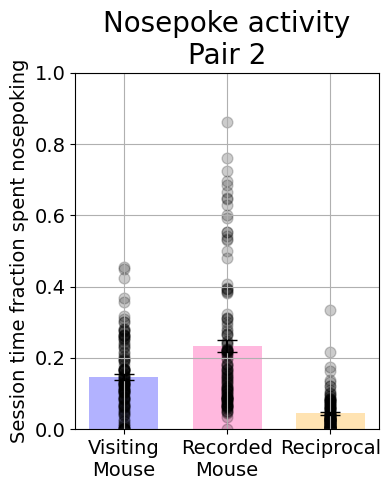

In [11]:
# Calculate means
mean_visiting_mouse = np.mean(pokes_ratio_matrix[:,0])
mean_recorded_mouse = np.mean(pokes_ratio_matrix[:,1])
mean_together = np.mean(pokes_ratio_matrix[:,2])

# Calculate standard errors
se_visiting_mouse = np.std(pokes_ratio_matrix[:,0]) / np.sqrt(len(pokes_ratio_matrix[:,0]))
se_recorded_mouse = np.std(pokes_ratio_matrix[:,1]) / np.sqrt(len(pokes_ratio_matrix[:,1]))
se_together = np.std(pokes_ratio_matrix[:,2]) / np.sqrt(len(pokes_ratio_matrix[:,2]))

# Bar plot
labels = ['Visiting\nMouse', 'Recorded\nMouse', 'Reciprocal']
means = [mean_visiting_mouse, mean_recorded_mouse, mean_together]
errors = [se_visiting_mouse, se_recorded_mouse, se_together]

# Plotting
plt.figure(figsize=(4,5))

# Adjust the spacing by multiplying the positions by a factor
spacing_factor = 0.3  # Increase this factor to increase space between bars
positions = np.arange(len(means)) * spacing_factor

# Plotting bars for means with adjusted positions
plt.bar(positions, means, yerr=errors, capsize=7, color=['blue', '#FF1493', 'orange'], alpha=0.3, width=0.2)

# Plot individual data points with adjusted positions
plt.scatter(np.zeros(len(pokes_ratio_matrix[:,0])) + positions[0], pokes_ratio_matrix[:,0], color='k', alpha=0.2, s=60)
plt.scatter(np.zeros(len(pokes_ratio_matrix[:,1])) + positions[1], pokes_ratio_matrix[:,1], color='k', alpha=0.2, s=60)
plt.scatter(np.zeros(len(pokes_ratio_matrix[:,2])) + positions[2], pokes_ratio_matrix[:,2], color='k', alpha=0.2, s=60)

# Customizing plot with adjusted labels
plt.xticks(positions, labels, fontsize=14)
plt.ylabel('Session time fraction spent nosepoking', fontsize=14)
plt.title(f'Nosepoke activity\nPair {pair}', fontsize=20)
plt.yticks(fontsize=14)
plt.ylim(0,1)
plt.grid(True)

plt.tight_layout()
plt.show()

To plot data regarding the blocks we can use the fact that data was aquired in a particular way: block 1,2,3,4 then again block 1,2,3,4

+ here we took sessions that are complete!

In [13]:
len(pokes_ratio_matrix)

121

In [12]:
# devide on blocks

blocks = []

for i in range(4):
    blocks.append(pokes_ratio_matrix[i::4,:].tolist())
blocks = np.array(blocks)
blocks

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [23]:
print(blocks)

[[[0.19715447 0.09146341 0.02845528]
  [0.22988506 0.24712644 0.07471264]
  [0.25170068 0.2244898  0.06802721]
  [0.14       0.22       0.06      ]
  [0.11111111 0.22222222 0.04678363]
  [0.13636364 0.38636364 0.09848485]]

 [[0.23236515 0.14937759 0.05809129]
  [0.28       0.10133333 0.04      ]
  [0.21505376 0.08387097 0.02795699]
  [0.12820513 0.15384615 0.02930403]
  [0.11464968 0.12738854 0.01592357]
  [0.16494845 0.16838488 0.02749141]]

 [[0.228125   0.115625   0.05625   ]
  [0.28057554 0.22302158 0.05755396]
  [0.44827586 0.22413793 0.13793103]
  [0.25495751 0.08215297 0.02832861]
  [0.08677686 0.11983471 0.02892562]
  [0.26241135 0.18439716 0.07801418]]

 [[0.23956044 0.05054945 0.03076923]
  [0.17948718 0.13782051 0.05448718]
  [0.19029851 0.11940299 0.02985075]
  [0.26479751 0.08411215 0.02492212]
  [0.20247934 0.13636364 0.03305785]
  [0.16906475 0.24460432 0.04316547]]]


In [36]:
# Mean values for each category in each block
blocks_means = []
for block in blocks:
    blocks_means.append(np.mean(block, axis=0).tolist())
blocks_means = np.array(blocks_means)
blocks_means

array([[0.13454833, 0.23866947, 0.042964  ],
       [0.11729784, 0.13021365, 0.0213412 ],
       [0.1582646 , 0.24152256, 0.04794799],
       [0.1135753 , 0.10526241, 0.01156914]])

In [37]:
blocks_se = []
for block in blocks:
    blocks_se.append((np.std(block, axis=0)/np.sqrt(len(block))).tolist())
blocks_se = np.array(blocks_se)
blocks_se

array([[0.05357142, 0.01702601, 0.01148705],
       [0.02368455, 0.02575896, 0.00544175],
       [0.02066269, 0.04976072, 0.01596397],
       [0.01262529, 0.02301267, 0.00294844]])

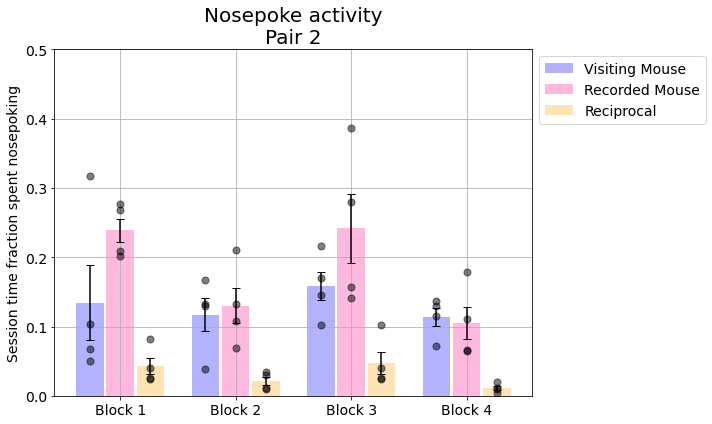

In [38]:
n_groups = len(blocks_means)  # Number of groups (Blocks)
n_bars = len(blocks_means[0])  # Number of bars in each group

# Bar setup
bar_width = 0.2
gap_between_groups = 0.2
gap_between_bars = 0.02

group_width = n_bars * bar_width + (n_bars - 1) * gap_between_bars
start_pos = np.arange(n_groups) * (group_width + gap_between_groups)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', '#FF1493', 'orange']
labels = ['Visiting Mouse', 'Recorded Mouse', 'Reciprocal']

for i in range(n_bars):
    bar_positions = start_pos + i * (bar_width + gap_between_bars)
    ax.bar(bar_positions, blocks_means[:, i], width=bar_width, yerr=blocks_se[:, i], capsize=4, color=colors[i], alpha=0.3, label=labels[i])

    # Plotting individual points directly on bar positions
    for j in range(n_groups):
        individual_pos = np.array([bar_positions[j]] * len(blocks[j, :, i]))  # This ensures direct alignment with the bars
        ax.scatter(individual_pos, blocks[j, :, i], color='k', s=50, zorder=3, alpha=0.5)

plt.xticks(start_pos + group_width / 2 - bar_width / 2, [f'Block {i+1}' for i in range(n_groups)], fontsize=14)
ax.set_ylabel('Session time fraction spent nosepoking', fontsize=14)
plt.yticks(fontsize=14)
ax.set_title(f'Nosepoke activity\nPair {pair}', fontsize=20)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1),  fontsize=14)

plt.grid(True)
plt.ylim(0,0.5)
plt.tight_layout()
plt.show()

## crosscorr

In [15]:
pokes_matrices_list = []
pair = 1
for path in txt_path_list_3C280_old: # here u play around with old/new pair data
    pokes_matrices_list.append(nosepoke_matrix(path, bin_size=500, logical=False))

In [38]:
import random

def nosepoke_crosscorr(matrix, bin_size=500):
    vis = matrix[:,0]
    rec = matrix[:,1]

    cor = np.correlate(vis, rec, mode='full')
    
    # control    
    cor_ctr = []
    for _ in range(100):
        random_shift = random.randint(10*1000/bin_size, 300*1000/bin_size) # shift in sec (from 10 to 300) --> in bins after deviding by bin_size
        rec_ctrl = np.zeros(len(rec))
        rec_ctrl[random_shift:] = rec[:-random_shift] #shift by x bins (x*500 ms)
        rec_ctrl[:random_shift] = rec[-random_shift:]
        cor_ctr.append(np.correlate(vis, rec_ctrl, mode='full'))
    cor_ctr = np.array(cor_ctr)
    
    # lags (for future plotting)
    lags = np.arange(-len(vis) + 1, len(vis))

    return cor, cor_ctr, lags

another option with shifting in both sides

In [27]:
def nosepoke_crosscorr(matrix, bin_size=500):
    vis = matrix[:,0]
    rec = matrix[:,1]

    cor = np.correlate(vis, rec, mode='full')
    
    # control    
    cor_ctr = []

    for _ in range(50): #shift in the right
        random_shift = random.randint(10*1000/bin_size, 300*1000/bin_size) # shift in sec (from 10 to 300) --> in bins after deviding by bin_size
        rec_ctrl = np.zeros(len(rec))
        rec_ctrl[random_shift:] = rec[:-random_shift] #shift by x bins (x*500 ms)
        rec_ctrl[:random_shift] = rec[-random_shift:]
        cor_ctr.append(np.correlate(vis, rec_ctrl, mode='full'))
    
    for _ in range(50): #shift in th left
        random_shift = random.randint(10*1000/bin_size, 300*1000/bin_size) # shift in sec (from 10 to 300) --> in bins after deviding by bin_size
        rec_ctrl = np.zeros(len(rec))
        rec_ctrl[random_shift:] = np.flip(rec)[:-random_shift] #shift by x bins (x*500 ms)
        rec_ctrl[:random_shift] = np.flip(rec)[-random_shift:]
        cor_ctr.append(np.correlate(vis, np.flip(rec_ctrl), mode='full'))

    cor_ctr = np.array(cor_ctr)
    
    # lags (for future plotting)
    lags = np.arange(-len(vis) + 1, len(vis))

    return cor, cor_ctr, lags

In [39]:
nosepoke_crosscorr_all = []
for matrix in pokes_matrices_list:
    nosepoke_crosscorr_all.append(nosepoke_crosscorr(matrix))

In [40]:
nosepoke_crosscorr_all[0] #data for 1 of the session blocks

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1735, -1734, -1733, ...,  1733,  1734,  1735]))

In [18]:
def corr_plot(nosepoke_crosscorr, zoom=10, bin_size=500, mean_corr_err=True):
    '''
    zoom = 10 --> [sec] cutoff from 0 +-10 sec lag
    bin_size=500 [ms]
    '''
    cor, cor_ctr, lags = nosepoke_crosscorr
    
    # 10 sec --> how many bins?
    zoom = zoom*1000/bin_size
    start = int(np.where(lags == 0)[0] - zoom)
    end = int(np.where(lags == 0)[0] + zoom + 1)

    # lags in bins --> lag in sec
    lags = lags*500/1000

    if mean_corr_err==True:
        # plot mean and shaded area as SEM
        mean_cor_ctr = np.mean(cor_ctr, axis=0)
        sem_mean_cor_ctr = np.std(cor_ctr, axis=0) / np.sqrt(len(cor_ctr))

        plt.plot(lags[start:end], cor[start:end], color='#008B8B')
        plt.plot(lags[start:end], mean_cor_ctr[start:end], color='#DC143C')
        plt.fill_between(lags[start:end], mean_cor_ctr[start:end] - sem_mean_cor_ctr[start:end], mean_cor_ctr[start:end] + sem_mean_cor_ctr[start:end], color='#DC143C', alpha=0.3)

    else:
        # plot all lines separately 
        for line in range(len(cor_ctr)):
            plt.plot(lags[start:end], cor_ctr[line,start:end], color='#DC143C', alpha=0.1)
        plt.plot(lags[start:end], cor[start:end], color='#008B8B')

    plt.ylabel('Cross-correlation')
    plt.xlabel("Lag, sec")
    plt.title('Nosepoke Cross-Correlation')
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
nosepoke_crosscorr_all[0][0].shape #

(3471,)

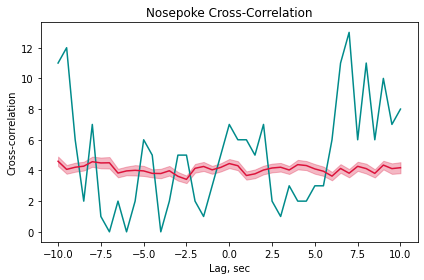

In [58]:
corr_plot(nosepoke_crosscorr_all[7], zoom=10)

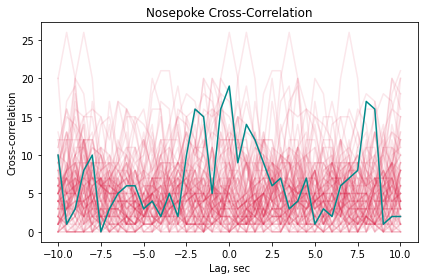

In [31]:
corr_plot(nosepoke_crosscorr_all[0], zoom=10, mean_corr_err=False)

The cross-correlation at lag k is obtained by multiplying each element of the first sequence (x[n]) by the corresponding element of the second sequence shifted by k time units (y[n−k]), and then summing up the products over all values of n.

In [150]:
# for i in range(len(nosepoke_crosscorr_all)):
#     corr_plot(nosepoke_crosscorr_all[i], zoom=10, bin_size=500)

In [152]:
# for i in range(len(nosepoke_crosscorr_all)):
#     corr_plot(nosepoke_crosscorr_all[i], mean_corr_err=False)

### If there is a reciprocal nosepokes?

we will search for peaks within +- 1 sec window

In [22]:
def peak_serch(nosepoke_crosscorr, zoom=1, bin_size=500):
    '''
    zoom = 1 --> [sec] cutoff from 0 +-1 sec lag
    bin_size=500 [ms]
    '''
    cor, cor_ctrl, lags = nosepoke_crosscorr

    # 10 sec --> how many bins?
    zoom = zoom*1000/bin_size
    start = int(np.where(lags == 0)[0] - zoom)
    end = int(np.where(lags == 0)[0] + zoom + 1)
    
    corr_peak = np.max(cor[start:end])
    # controls peaks
    cor_ctrl_peaks = []
    for i in range(len(cor_ctrl)):
        cor_ctrl_peaks.append(np.max(cor_ctrl[i, start:end]))

    return corr_peak, cor_ctrl_peaks

In [56]:
corr_peak, cor_ctrl_peaks = peak_serch(nosepoke_crosscorr_all[7], zoom=1, bin_size=500)

In [42]:
corr_peak

19.0

In [43]:
cor_ctrl_peaks

[15.0,
 11.0,
 4.0,
 9.0,
 18.0,
 12.0,
 12.0,
 2.0,
 6.0,
 6.0,
 6.0,
 2.0,
 16.0,
 8.0,
 16.0,
 5.0,
 8.0,
 8.0,
 9.0,
 13.0,
 14.0,
 12.0,
 10.0,
 9.0,
 6.0,
 13.0,
 16.0,
 4.0,
 9.0,
 15.0,
 12.0,
 5.0,
 10.0,
 5.0,
 6.0,
 2.0,
 5.0,
 5.0,
 8.0,
 4.0,
 9.0,
 16.0,
 20.0,
 3.0,
 3.0,
 6.0,
 7.0,
 3.0,
 6.0,
 9.0,
 8.0,
 3.0,
 9.0,
 6.0,
 3.0,
 4.0,
 4.0,
 5.0,
 16.0,
 2.0,
 9.0,
 2.0,
 9.0,
 4.0,
 8.0,
 4.0,
 8.0,
 11.0,
 9.0,
 4.0,
 26.0,
 12.0,
 7.0,
 2.0,
 1.0,
 12.0,
 5.0,
 13.0,
 17.0,
 12.0,
 20.0,
 12.0,
 9.0,
 6.0,
 13.0,
 7.0,
 6.0,
 7.0,
 11.0,
 15.0,
 12.0,
 7.0,
 7.0,
 9.0,
 4.0,
 9.0,
 4.0,
 5.0,
 2.0,
 7.0]

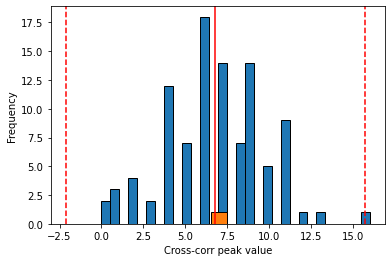

In [57]:
plt.hist(cor_ctrl_peaks, bins=30, edgecolor='black')  # 'bins' determines the number of bins
#plt.title('Distribution of Measurements')
plt.hist(corr_peak, bins=1, edgecolor='black') 

plt.axvline(x=np.mean(np.array(cor_ctrl_peaks)), color='r')
plt.axvline(x=np.mean(np.array(cor_ctrl_peaks))+np.std(np.array(cor_ctrl_peaks))*3, color='r', linestyle='--', label='x=5')
plt.axvline(x=np.mean(np.array(cor_ctrl_peaks))-np.std(np.array(cor_ctrl_peaks))*3, color='r', linestyle='--', label='x=5')

plt.xlabel('Cross-corr peak value')
plt.ylabel('Frequency')
plt.show()

In [36]:
from scipy import stats

In [47]:
# Perform the Shapiro-Wilk Test
stat, p = stats.shapiro(cor_ctrl_peaks)

# Interpret the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


ok, our ctrl distribution of peaks is not gaussian --> we will try some non-parametric tests:

**Wilcoxon Signed-Rank Test**
This test is a better fit if you treat your single observation as a hypothesized median of the distribution and wish to test if the sample median significantly differs from this value. It's used for paired samples or single samples against a hypothetical median. This might be your go-to method if you interpret your single observation in such a way.

In [49]:
from scipy.stats import wilcoxon

# Your sample data
sample_data = np.array(cor_ctrl_peaks)  # Your non-Gaussian sample

# Your observation value treated as a hypothesized median
observation_value = corr_peak

# Subtract the observation value from each sample point
# to create a difference from the hypothesized median
differences = sample_data - observation_value

# Perform the Wilcoxon signed-rank test
stat, p = wilcoxon(differences)

# Interpret the result
alpha = 0.05
if p > alpha:
    print('The sample median is not significantly different from the observation (fail to reject H0)')
else:
    print('The sample median is significantly different from the observation (reject H0)')

The sample median is significantly different from the observation (reject H0)


now lets automatize it for all session blocks

In [ ]:
from scipy import stats
from scipy.stats import wilcoxon

In [50]:
normality_results = [] # 1 - not normal, 0 - normal
stat_diff_results = [] # 1 - different, 2 - no stat difference
for i in range(len(nosepoke_crosscorr_all)):
    corr_peak, cor_ctrl_peaks = peak_serch(nosepoke_crosscorr_all[i], zoom=1, bin_size=500)
    # normality
    stat, p = stats.shapiro(cor_ctrl_peaks)
    alpha = 0.05
    if p > alpha:
        # Sample looks Gaussian (fail to reject H0)
        normality_results.append(0)
    else:
        # Sample does not look Gaussian (reject H0)
        normality_results.append(1)

    # stat diff
    differences = np.array(cor_ctrl_peaks) - corr_peak
    stat, p = wilcoxon(differences)
    alpha = 0.05
    if p > alpha:
        # The sample median is not significantly different from the observation (fail to reject H0)
        stat_diff_results.append(0)
    else:
        # The sample median is significantly different from the observation (reject H0)
        stat_diff_results.append(1)

normality_results = np.array(normality_results)
stat_diff_results = np.array(stat_diff_results)

In [51]:
np.sum(normality_results)/len(normality_results), np.sum(stat_diff_results)/len(stat_diff_results)

(0.8333333333333334, 0.8333333333333334)

In [52]:
np.where(normality_results == 0)

(array([ 2,  3,  7, 17], dtype=int64),)

In [53]:
np.where(stat_diff_results == 0)

(array([ 5,  7, 18, 22], dtype=int64),)

### If there is a pattern n nosepokes?

we will search for peaks within +- 5 sec window

In [67]:
corr_peak, cor_ctrl_peaks = peak_serch(nosepoke_crosscorr_all[0], zoom=10, bin_size=500)

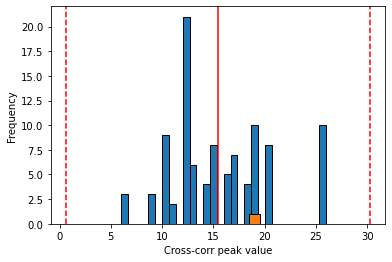

In [68]:
plt.hist(cor_ctrl_peaks, bins=30, edgecolor='black')  # 'bins' determines the number of bins
#plt.title('Distribution of Measurements')
plt.hist(corr_peak, bins=1, edgecolor='black') 

plt.axvline(x=np.mean(np.array(cor_ctrl_peaks)), color='r')
plt.axvline(x=np.mean(np.array(cor_ctrl_peaks))+np.std(np.array(cor_ctrl_peaks))*3, color='r', linestyle='--', label='x=5')
plt.axvline(x=np.mean(np.array(cor_ctrl_peaks))-np.std(np.array(cor_ctrl_peaks))*3, color='r', linestyle='--', label='x=5')

plt.xlabel('Cross-corr peak value')
plt.ylabel('Frequency')
plt.show()

In [69]:
# Perform the Shapiro-Wilk Test
stat, p = stats.shapiro(cor_ctrl_peaks)

# Interpret the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


In [70]:
# Your sample data
sample_data = np.array(cor_ctrl_peaks)  # Your non-Gaussian sample

# Your observation value treated as a hypothesized median
observation_value = corr_peak

# Subtract the observation value from each sample point
# to create a difference from the hypothesized median
differences = sample_data - observation_value

# Perform the Wilcoxon signed-rank test
stat, p = wilcoxon(differences)

# Interpret the result
alpha = 0.05
if p > alpha:
    print('The sample median is not significantly different from the observation (fail to reject H0)')
else:
    print('The sample median is significantly different from the observation (reject H0)')

The sample median is significantly different from the observation (reject H0)


In [71]:
normality_results = [] # 1 - not normal, 0 - normal
stat_diff_results = [] # 1 - different, 2 - no stat difference
for i in range(len(nosepoke_crosscorr_all)):
    corr_peak, cor_ctrl_peaks = peak_serch(nosepoke_crosscorr_all[i], zoom=1, bin_size=500)
    # normality
    stat, p = stats.shapiro(cor_ctrl_peaks)
    alpha = 0.05
    if p > alpha:
        # Sample looks Gaussian (fail to reject H0)
        normality_results.append(0)
    else:
        # Sample does not look Gaussian (reject H0)
        normality_results.append(1)

    # stat diff
    differences = np.array(cor_ctrl_peaks) - corr_peak
    stat, p = wilcoxon(differences)
    alpha = 0.05
    if p > alpha:
        # The sample median is not significantly different from the observation (fail to reject H0)
        stat_diff_results.append(0)
    else:
        # The sample median is significantly different from the observation (reject H0)
        stat_diff_results.append(1)

normality_results = np.array(normality_results)
stat_diff_results = np.array(stat_diff_results)

In [72]:
np.sum(normality_results)/len(normality_results), np.sum(stat_diff_results)/len(stat_diff_results)

(0.8333333333333334, 0.8333333333333334)

In [73]:
np.where(normality_results == 0)

(array([ 2,  3,  7, 17], dtype=int64),)

In [74]:
np.where(stat_diff_results == 0)

(array([ 5,  7, 18, 22], dtype=int64),)